In [2]:
# Курсовая работа: Машинное обучение и анализ данных (Вариант 9)
# Условие: VPLDAGNR ∈ {0,1,2}
# Целевая: 'KHVM'

# 0. УСТАНОВКА И ИМПОРТ
# --------------------
# pip install pandas numpy matplotlib seaborn scikit-learn h2o

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import h2o
from h2o.automl import H2OAutoML

In [3]:
# 1. ЗАГРУЗКА И ФИЛЬТРАЦИЯ ДАННЫХ
df = pd.read_csv('Dataset_2_DATA.csv')
df = df[df['VPLDAGNR'].isin([0, 1, 2])].reset_index(drop=True)
print(f"Shape after filter: {df.shape}")

# Удаляем константные/пустые столбцы
const_cols = [c for c in df.columns if df[c].nunique() <= 1]
df.drop(columns=const_cols, inplace=True)
print("Dropped constant columns:", const_cols)

# Проверка пропусков
print("Missing values per column:\n", df.isna().sum())

Shape after filter: (4902, 56)
Dropped constant columns: ['HH_VALID', 'P_VALID', 'WEGGEWEEST']
Missing values per column:
 HHID                       0
PERSID                     0
VPLID                      0
RitID                      0
KHVM                       0
VERTREKP                   0
AANTVPL                    0
VPLDAGNR                   0
VERPL                      0
VERPLNR                    0
TOER                       0
TOER_TYPE                  0
AANTRIT                    0
KMOTIEF                    0
VERTPROV                   0
AANKPROV                   0
KAFSTV                     0
KVERTTIJD                  0
KREISDUUR                  0
ROLAUTO                    0
PARKEERKOSTEN              0
VERTRAGING                 0
DAGSOORT                   0
OORDEEL_AUTO               0
OORDEEL_TREIN              0
OORDEEL_BTM                0
OORDEEL_FIETS              0
OORDEEL_BROMMER            0
OORDEEL_LOPEN              0
GEBRUIK_AUTO_STELLING3     0
GEBRUIK

строки с пропущенными значениями в столбцах были удалены из датасета для обучения модели

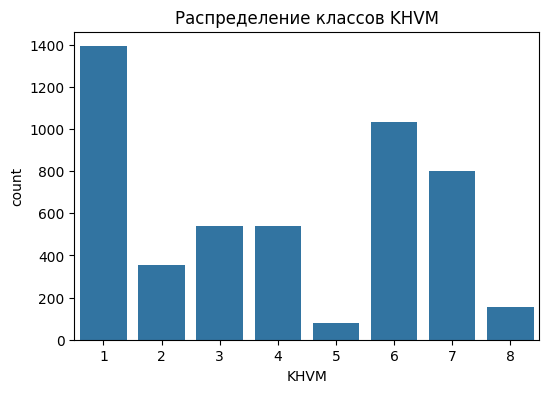

                          count          mean           std           min  \
HHID                     4902.0  3.256728e+07  7.344586e+06  3.001044e+07   
PERSID                   4902.0  3.256728e+09  7.344586e+08  3.001044e+09   
VPLID                    4902.0  1.740965e+07  2.544355e+06  1.306810e+07   
RitID                    4902.0  1.740965e+09  2.544355e+08  1.306810e+09   
KHVM                     4902.0  3.946552e+00  2.407904e+00  1.000000e+00   
VERTREKP                 4902.0  1.145247e+00  3.682414e-01  1.000000e+00   
AANTVPL                  4902.0  4.312933e+00  2.299009e+00  1.000000e+00   
VPLDAGNR                 4902.0  1.496736e+00  5.008558e-01  0.000000e+00   
VERPL                    4902.0  8.531212e-01  5.348967e-01  0.000000e+00   
VERPLNR                  4902.0  2.640555e+00  1.807320e+00  1.000000e+00   
TOER                     4902.0  5.038760e-02  2.187657e-01  0.000000e+00   
TOER_TYPE                4902.0  8.695022e+00  1.396578e+00  1.000000e+00   

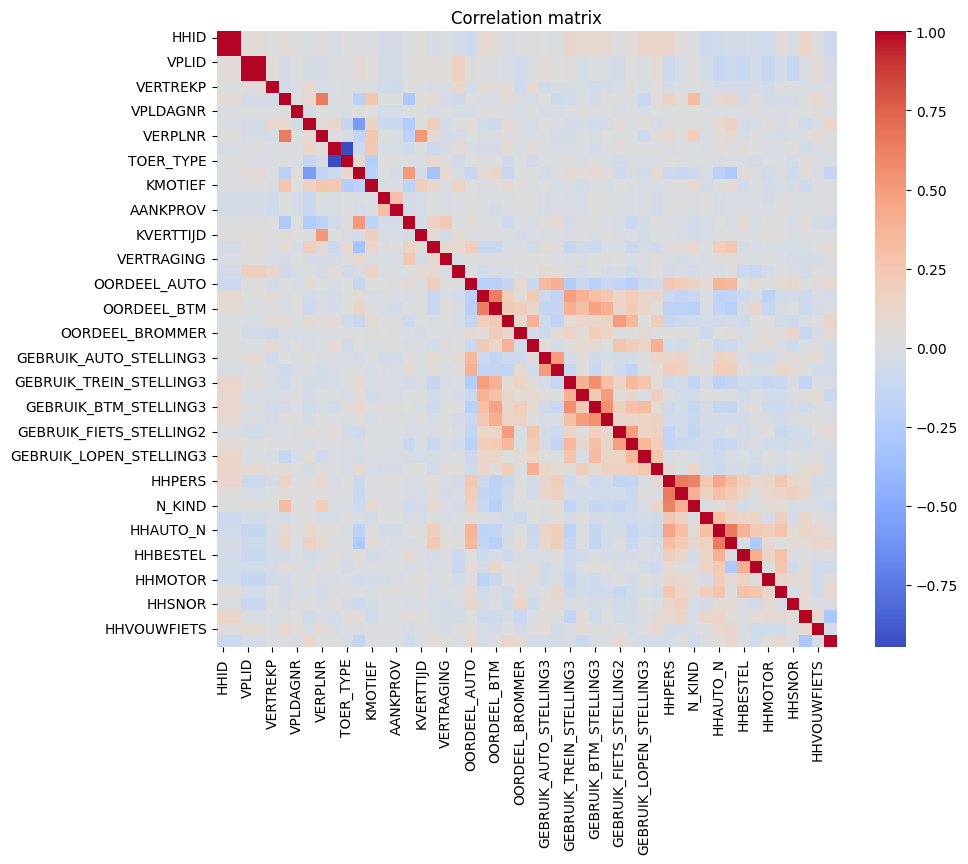

In [4]:
# 2. EDA
plt.figure(figsize=(6,4))
sns.countplot(x='KHVM', data=df)
plt.title('Распределение классов KHVM')
plt.show()

print(df.describe(include=[np.number]).T)

num_cols = df.select_dtypes(include=[np.number]).columns.drop('KHVM')
corr = df[num_cols].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap='coolwarm')
plt.title('Correlation matrix')
plt.show()


In [5]:
# 3. ДОПОЛНИТЕЛЬНАЯ ОБРАБОТКА ПРИЗНАКОВ
# ------------------------------------

# 3.1. Удаляем идентификаторы — они не несут полезной информации для модели
id_cols = ['HHID', 'PERSID', 'VPLID', 'RitID']
to_drop = [c for c in id_cols if c in df.columns]
df.drop(columns=to_drop, inplace=True)
print("Удалены ID-поля:", to_drop)

# 3.2. Удаляем один из сильно коррелирующих признаков провинций
#      Мы видели, что VERTPROV и AANKPROV почти полностью дублируют друг друга.
#      Оставим VERTPROV и уберём AANKPROV.
if 'AANKPROV' in df.columns:
    df.drop(columns=['AANKPROV'], inplace=True)
    print("Удалён дублирующий признак провинции: AANKPROV")

# 3.3. Ещё раз автоматически убираем любые константные столбцы (если остались)
const_cols = [c for c in df.columns if df[c].nunique() <= 1]
if const_cols:
    df.drop(columns=const_cols, inplace=True)
    print("Авто-удалены константные столбцы:", const_cols)
else:
    print("Константных столбцов не обнаружено")

# 3.4. Проверяем итоговый список признаков
print("Оставшиеся признаки (count={}):".format(len(df.columns)), df.columns.tolist())


Удалены ID-поля: ['HHID', 'PERSID', 'VPLID', 'RitID']
Удалён дублирующий признак провинции: AANKPROV
Константных столбцов не обнаружено
Оставшиеся признаки (count=48): ['KHVM', 'VERTREKP', 'AANTVPL', 'VPLDAGNR', 'VERPL', 'VERPLNR', 'TOER', 'TOER_TYPE', 'AANTRIT', 'KMOTIEF', 'VERTPROV', 'KAFSTV', 'KVERTTIJD', 'KREISDUUR', 'ROLAUTO', 'PARKEERKOSTEN', 'VERTRAGING', 'DAGSOORT', 'OORDEEL_AUTO', 'OORDEEL_TREIN', 'OORDEEL_BTM', 'OORDEEL_FIETS', 'OORDEEL_BROMMER', 'OORDEEL_LOPEN', 'GEBRUIK_AUTO_STELLING3', 'GEBRUIK_AUTO_STELLING4', 'GEBRUIK_TREIN_STELLING3', 'GEBRUIK_TREIN_STELLING4', 'GEBRUIK_BTM_STELLING3', 'GEBRUIK_BTM_STELLING4', 'GEBRUIK_FIETS_STELLING2', 'GEBRUIK_FIETS_STELLING3', 'GEBRUIK_LOPEN_STELLING3', 'GEBRUIK_LOPEN_STELLING4', 'HHPERS', 'HHSAM', 'N_KIND', 'HHBRUTOINK2_w5', 'HHAUTO_N', 'HHAUTO', 'HHBESTEL', 'HHHYBRID', 'HHMOTOR', 'HHBROM', 'HHSNOR', 'HHFIETS', 'HHVOUWFIETS', 'HHEBIKE']


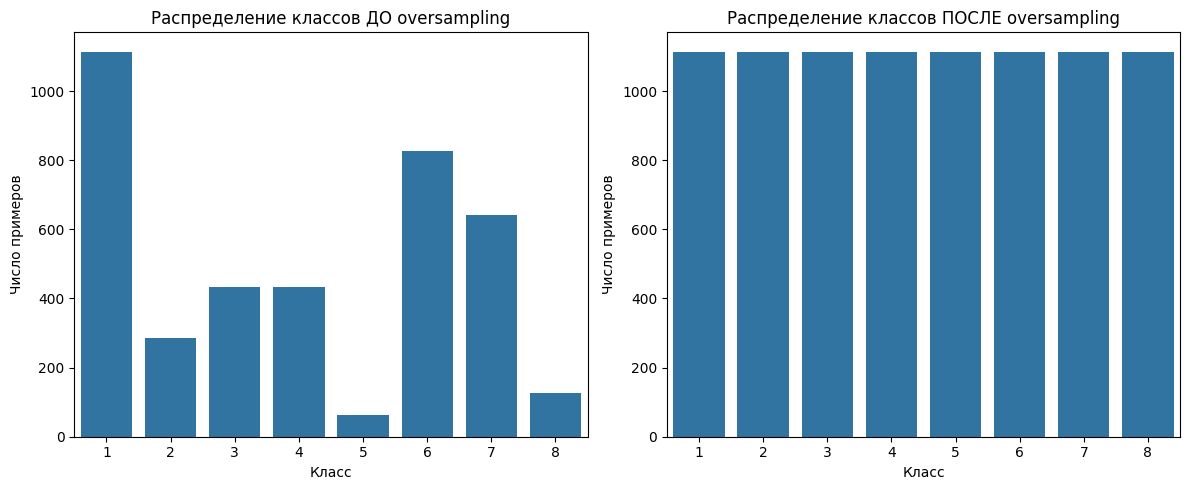

In [ ]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

# 4. Формируем X и y и разбиваем выборку (80/20), сохраняя пропорции классов
X = df.drop(columns=['KHVM'])
y = df['KHVM']
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# 5. RandomOverSampler для редких классов (5 и 8)
ros = RandomOverSampler(
    random_state=42
)

# 5.1 Сохраняем распределение классов до oversampling
y_before = y_train.value_counts()

# 5.2 Применяем oversampling (ваш существующий код)
X_train, y_train = ros.fit_resample(X_train, y_train)

# 5.3 Визуализация распределения классов до и после
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# До oversampling
sns.barplot(x=y_before.index, y=y_before.values, ax=axes[0])
axes[0].set_title('Распределение классов ДО oversampling')
axes[0].set_xlabel('Класс')
axes[0].set_ylabel('Число примеров')

# После oversampling
sns.countplot(x=y_train, ax=axes[1])
axes[1].set_title('Распределение классов ПОСЛЕ oversampling')
axes[1].set_xlabel('Класс')
axes[1].set_ylabel('Число примеров')

plt.tight_layout()
plt.show()


In [12]:
# 6. Определяем препроцессор для числовых и категориальных признаков
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

numeric_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()  # все числовые
cat_cols     = X.select_dtypes(include=['object','category']).columns.tolist() # все категориальные

numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),    # заполняем пропуски медианой
    ('scaler',   StandardScaler())                    # масштабируем (mean=0, std=1)
])
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),  # заполняем модой
    ('ohe',      OneHotEncoder(handle_unknown='ignore', sparse_output=False))  
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_cols),
    ('cat', categorical_pipeline, cat_cols),
])

# 7. Подбор гиперпараметров RandomForest через GridSearchCV
from sklearn.model_selection import GridSearchCV

# Диапазон параметров:
# - n_estimators: число деревьев (чем больше — тем стабильнее, но дольше обучается)
# - max_depth: максимальная глубина дерева (ограничивает переобучение)
# - min_samples_split: мин. число примеров в узле для разбиения (больше — проще дерево)
param_grid = {
    'clf__n_estimators':       [100, 200, 500],
    'clf__max_depth':          [None, 10, 20, 30],
    'clf__min_samples_split':  [2, 5, 10],
}

# Собираем единый конвейер: препроцессор → классификатор
pipe = Pipeline([
    ('pre', preprocessor),
    ('clf', RandomForestClassifier(random_state=42))
])

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=5,                # кросс-валидация 5 фолдов
    scoring='accuracy',  # метрика качества
    n_jobs=1             # последовательно, чтобы не было проблем с параллелизмом
)

# 8. Обучаем GridSearch на сбалансированных данных
grid.fit(X_train, y_train)

# 9. Выводим лучшие параметры и метрики на тесте
print("Лучшие параметры RF:", grid.best_params_)
y_pred = grid.predict(X_test)
print("Accuracy (GridSearchCV):", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Лучшие параметры RF: {'clf__max_depth': None, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}
Accuracy (GridSearchCV): 0.9653414882772681
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       279
           2       1.00      1.00      1.00        71
           3       1.00      1.00      1.00       109
           4       1.00      1.00      1.00       108
           5       0.94      1.00      0.97        16
           6       0.92      0.92      0.92       207
           7       0.90      0.90      0.90       160
           8       1.00      0.97      0.98        31

    accuracy                           0.97       981
   macro avg       0.97      0.97      0.97       981
weighted avg       0.97      0.97      0.97       981



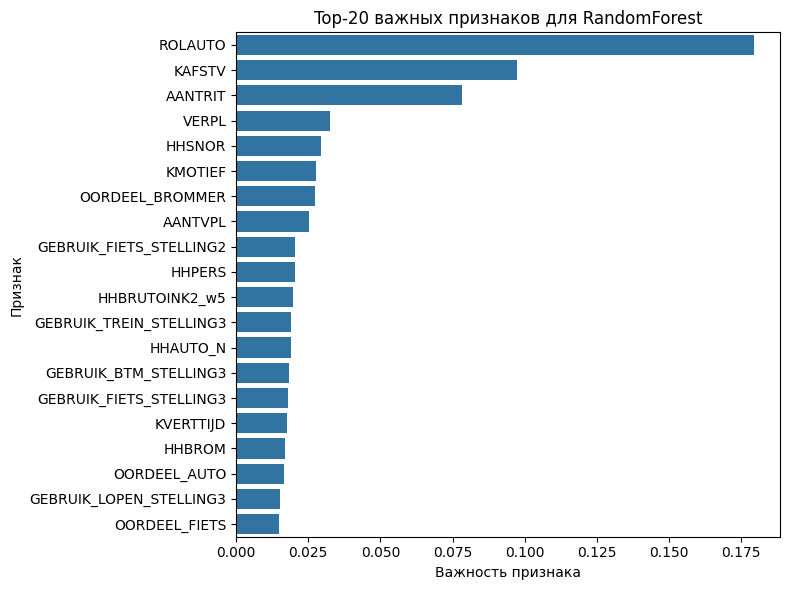

Top-20 признаков и их важности:
                     feature  importance
0                   ROLAUTO    0.179485
1                    KAFSTV    0.097260
2                   AANTRIT    0.078384
3                     VERPL    0.032400
4                    HHSNOR    0.029414
5                   KMOTIEF    0.027559
6           OORDEEL_BROMMER    0.027151
7                   AANTVPL    0.025092
8   GEBRUIK_FIETS_STELLING2    0.020340
9                    HHPERS    0.020259
10           HHBRUTOINK2_w5    0.019814
11  GEBRUIK_TREIN_STELLING3    0.019099
12                 HHAUTO_N    0.018961
13    GEBRUIK_BTM_STELLING3    0.018357
14  GEBRUIK_FIETS_STELLING3    0.018036
15                KVERTTIJD    0.017676
16                   HHBROM    0.016961
17             OORDEEL_AUTO    0.016573
18  GEBRUIK_LOPEN_STELLING3    0.015318
19            OORDEEL_FIETS    0.014943


In [14]:
# 9. Анализ важности признаков (Manual RF)
# ----------------------------------------

# 9.1 Достаём обученный RandomForest из GridSearchCV
best_rf = grid.best_estimator_.named_steps['clf']

# 9.2 Формируем список имён признаков после препроцессинга
feat_num = numeric_cols
feat_cat = grid.best_estimator_.named_steps['pre'] \
    .named_transformers_['cat'] \
    .named_steps['ohe'] \
    .get_feature_names_out(cat_cols).tolist()
feature_names = feat_num + feat_cat

# 9.3 Получаем вектор importances и выбираем топ-20
importances = best_rf.feature_importances_
indices = importances.argsort()[::-1][:20]

# 9.4 Визуализация топ-20 самых важных признаков
plt.figure(figsize=(8, 6))
sns.barplot(
    x=importances[indices],
    y=[feature_names[i] for i in indices]
)
plt.title('Top-20 важных признаков для RandomForest')
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.tight_layout()
plt.show()

# 9.5 (Опционально) Выводим таблицу топ-20
top20 = [(feature_names[i], importances[i]) for i in indices]
print("Top-20 признаков и их важности:\n", pd.DataFrame(top20, columns=['feature','importance']))


100%|===================| 7845/7848 [03:13<00:00]        


=== Observation 0, predicted class = 1 ===


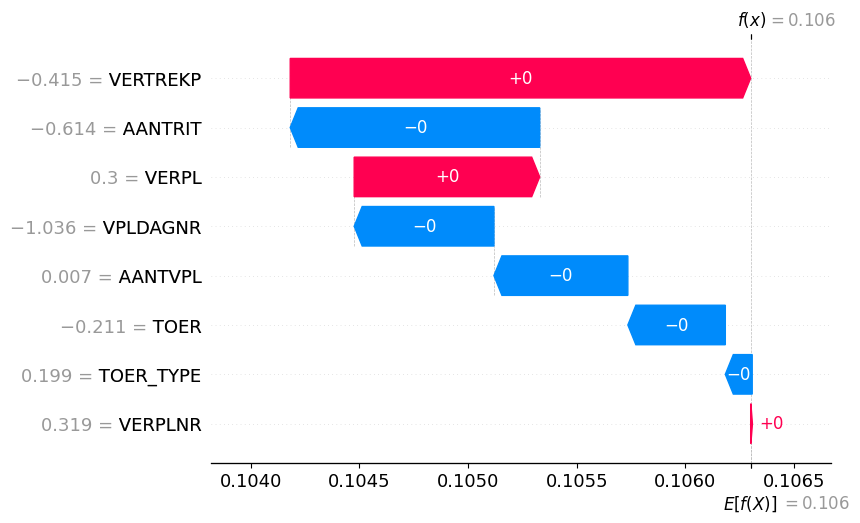


=== Observation 1, predicted class = 1 ===


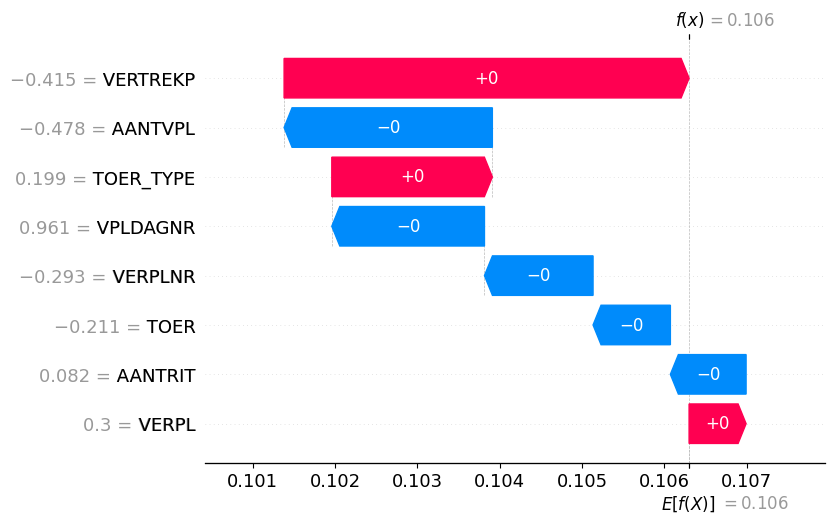


=== Observation 2, predicted class = 4 ===


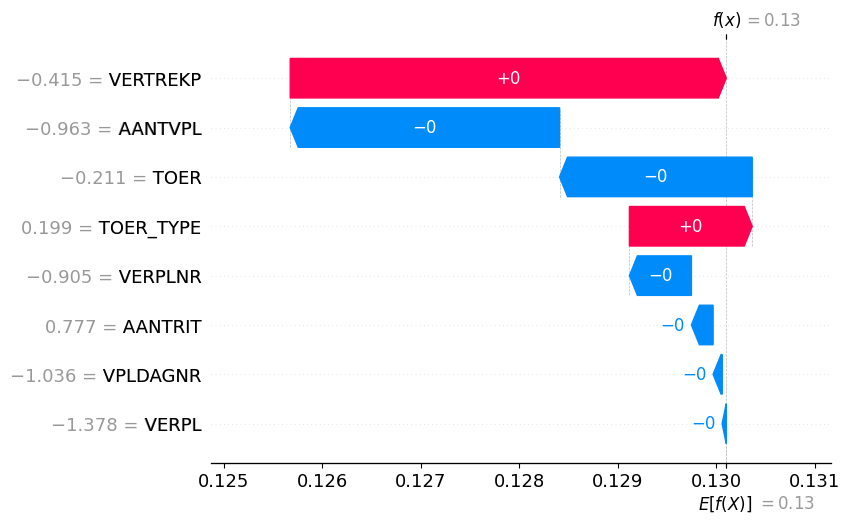

In [21]:
# 10A. Локальная интерпретация — Waterfall Plot для трёх примеров
import shap
import pandas as pd

# Используем уже обученные pre и clf из GridSearchCV
pre = grid.best_estimator_.named_steps['pre']
clf = grid.best_estimator_.named_steps['clf']

# Преобразуем тестовую выборку
X_test_p = pre.transform(X_test)

# Создаём TreeExplainer (probabilities)
explainer = shap.TreeExplainer(clf, pre.transform(X_train), model_output="probability")
shap_values = explainer.shap_values(X_test_p, check_additivity=False)

# Для трёх примеров (индексы 0,1,2) строим Waterfall Plot
for idx in [0, 1, 2]:
    # предсказанный класс и его индекс в shap_values
    cls       = clf.predict(X_test_p[idx].reshape(1, -1))[0]
    cls_idx   = list(clf.classes_).index(cls)
    
    # вектор SHAP-значений для этого примера
    sv = shap_values[cls_idx][idx]
    # гарантируем совпадение длины с количеством признаков
    if len(sv) != len(feature_names):
        sv = sv[:len(feature_names)]
    
    # создаём Series для удобства отображения
    feat_series = pd.Series(X_test_p[idx], index=feature_names)
    
    # формируем Explanation-объект
    expl = shap.Explanation(
        values=sv,
        base_values=explainer.expected_value[cls_idx],
        data=feat_series,
        feature_names=feature_names
    )
    
    print(f"\n=== Observation {idx}, predicted class = {cls} ===")
    shap.plots.waterfall(expl)


In [22]:
# 5. BASELINE AutoML (H2O)
# ------------------------
h2o.init(max_mem_size='2G', nthreads=-1)
h2o_df = h2o.H2OFrame(pd.concat([X, y], axis=1))
h2o_df['KHVM'] = h2o_df['KHVM'].asfactor()
train_h2o, test_h2o = h2o_df.split_frame(ratios=[0.8], seed=42)

features = [c for c in h2o_df.columns if c != 'KHVM']
learning_time = 300
aml = H2OAutoML(max_runtime_secs=learning_time, seed=42)
aml.train(x=features, y='KHVM', training_frame=train_h2o)

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "21" 2023-09-19; OpenJDK Runtime Environment (build 21+35-2513); OpenJDK 64-Bit Server VM (build 21+35-2513, mixed mode, sharing)
  Starting server from /Users/andrew/vscode_projects/coursework_ml/venv/lib/python3.11/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/jd/kkmnjfgd3zjfxt0jb2p4gdy40000gn/T/tmp3tx7pmn5
  JVM stdout: /var/folders/jd/kkmnjfgd3zjfxt0jb2p4gdy40000gn/T/tmp3tx7pmn5/h2o_andrew_started_from_python.out
  JVM stderr: /var/folders/jd/kkmnjfgd3zjfxt0jb2p4gdy40000gn/T/tmp3tx7pmn5/h2o_andrew_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Moscow
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,1 month and 23 days
H2O_cluster_name:,H2O_from_python_andrew_pqh7fx
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.984 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
19:08:54.290: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████████████| (done) 100%


key,value
Stacking strategy,cross_validation
Number of base models (used / total),5/5
# GBM base models (used / total),1/1
# DRF base models (used / total),2/2
# GLM base models (used / total),1/1
# DeepLearning base models (used / total),1/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5
Metalearner fold_column,None


Первый базовый H2O-модель: GBM_grid_1_AutoML_1_20250520_190854_model_10
Top 20 H2O variable importances:
                    variable  relative_importance  scaled_importance  \
0                   ROLAUTO          3324.707520           1.000000   
1                    KAFSTV          1572.698730           0.473034   
2                   AANTRIT          1181.289185           0.355306   
3                 KREISDUUR           330.468903           0.099398   
4                     VERPL           199.593262           0.060033   
5                 TOER_TYPE           183.166183           0.055092   
6                      TOER           139.573334           0.041981   
7                   KMOTIEF           135.987869           0.040902   
8                  HHAUTO_N            90.368187           0.027181   
9            HHBRUTOINK2_w5            83.986984           0.025261   
10            OORDEEL_FIETS            81.461357           0.024502   
11  GEBRUIK_FIETS_STELLING3            80.

/Users/andrew/vscode_projects/coursework_ml/venv/lib/python3.11/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


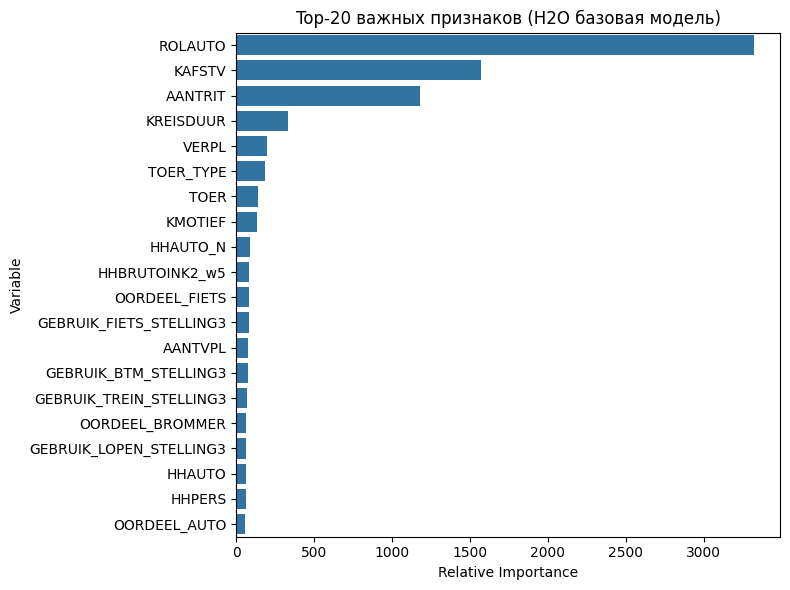

In [24]:
# 11. СРАВНЕНИЕ важностей признаков с H2O AutoML
# ------------------------------------------------

# 11.1. Получаем leaderboard из H2OAutoML
lb = aml.leaderboard.as_data_frame()

# 11.2. Ищем первую базовую модель (не StackedEnsemble)
base_model_id = lb[~lb['model_id'].str.startswith('StackedEnsemble')].iloc[0]['model_id']
print("Первый базовый H2O-модель:", base_model_id)

# 11.3. Загружаем её из кластера
base_model = h2o.get_model(base_model_id)

# 11.4. Извлекаем varimp как pandas.DataFrame
varimp = base_model.varimp(use_pandas=True)
print("Top 20 H2O variable importances:\n", varimp.head(20))

# 11.5. Визуализируем Top-20
varimp_top20 = varimp.head(20)
plt.figure(figsize=(8,6))
sns.barplot(
    x='relative_importance',
    y='variable',
    data=varimp_top20,
    orient='h'
)
plt.title('Top-20 важных признаков (H2O базовая модель)')
plt.xlabel('Relative Importance')
plt.ylabel('Variable')
plt.tight_layout()
plt.show()


In [25]:
# 9. Завершение
# -------------
h2o.cluster().shutdown(prompt=False)


In [28]:
# 12. Сравнение итоговых метрик RF vs H2O
# ---------------------------------------

# 12.1. RF (GridSearchCV) метрики уже были:
#     y_pred_rf = grid.predict(X_test)
#     Пусть y_pred_rf — ваши предсказания для RF:

y_pred_rf = grid.predict(X_test)

# 12.2. H2O: предсказываем на том же X_test
# Преобразуем pandas → H2OFrame
h2o_test = h2o.H2OFrame(X_test)

# Предсказания (столбец "predict" содержит метки 1–8)
h2o_pred = base_model.predict(h2o_test)
h2o_pred_series = h2o_pred.as_data_frame()['predict']

# 12.3. Считаем accuracy и classification_report для обеих моделей
rf_acc  = accuracy_score(y_test, y_pred_rf)
h2o_acc = accuracy_score(y_test, h2o_pred_series)

rf_cr  = classification_report(y_test, y_pred_rf,  output_dict=True)
h2o_cr = classification_report(y_test, h2o_pred_series, output_dict=True)

# 12.4. Собираем в одну таблицу
# Сначала df для RF, потом для H2O, ставим MultiIndex колонок
df_rf  = pd.DataFrame(rf_cr).T
df_h2o = pd.DataFrame(h2o_cr).T

df_compare = pd.concat(
    [df_rf[['precision','recall','f1-score','support']],
     df_h2o[['precision','recall','f1-score','support']]],
    axis=1,
    keys=['RF', 'H2O']
)

# 12.5. Добавляем общую accuracy сверху
summary = pd.DataFrame({
    ('RF','accuracy'): [rf_acc],
    ('H2O','accuracy'): [h2o_acc]
}, index=['accuracy'])

# 12.6. Выводим итоговую таблицу
print("Сравнение метрик по классам (RF vs H2O):")
display(pd.concat([summary, df_compare]))


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Сравнение метрик по классам (RF vs H2O):


/Users/andrew/vscode_projects/coursework_ml/venv/lib/python3.11/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


RF       H2O        RF                                  \
              accuracy  accuracy precision    recall  f1-score     support   
accuracy      0.965341  0.992864       NaN       NaN       NaN         NaN   
1                  NaN       NaN  1.000000  0.996416  0.998205  279.000000   
2                  NaN       NaN  1.000000  1.000000  1.000000   71.000000   
3                  NaN       NaN  1.000000  1.000000  1.000000  109.000000   
4                  NaN       NaN  1.000000  1.000000  1.000000  108.000000   
5                  NaN       NaN  0.941176  1.000000  0.969697   16.000000   
6                  NaN       NaN  0.918269  0.922705  0.920482  207.000000   
7                  NaN       NaN  0.900000  0.900000  0.900000  160.000000   
8                  NaN       NaN  1.000000  0.967742  0.983607   31.000000   
accuracy           NaN       NaN  0.965341  0.965341  0.965341    0.965341   
macro avg          NaN       NaN  0.969931  0.973358  0.971499  981.000000   
weighted avg       NaN       NaN  0.965485  0.965341  0.965388  981.000000   

                   H2O                                  
             precision    recall  f1-score     support  
accuracy           NaN       NaN       NaN         NaN  
1             1.000000  1.000000  1.000000  279.000000  
2             1.000000  1.000000  1.000000   71.000000  
3             0.990909  1.000000  0.995434  109.000000  
4             1.000000  0.990741  0.995349  108.000000  
5             1.000000  1.000000  1.000000   16.000000  
6             0.990244  0.980676  0.985437  207.000000  
7             0.975460  0.993750  0.984520  160.000000  
8             1.000000  0.967742  0.983607   31.000000  
accuracy      0.992864  0.992864  0.992864    0.992864  
macro avg     0.994577  0.991614  0.993043  981.000000  
weighted avg  0.992929  0.992864  0.992865  981.000000

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


/Users/andrew/vscode_projects/coursework_ml/venv/lib/python3.11/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


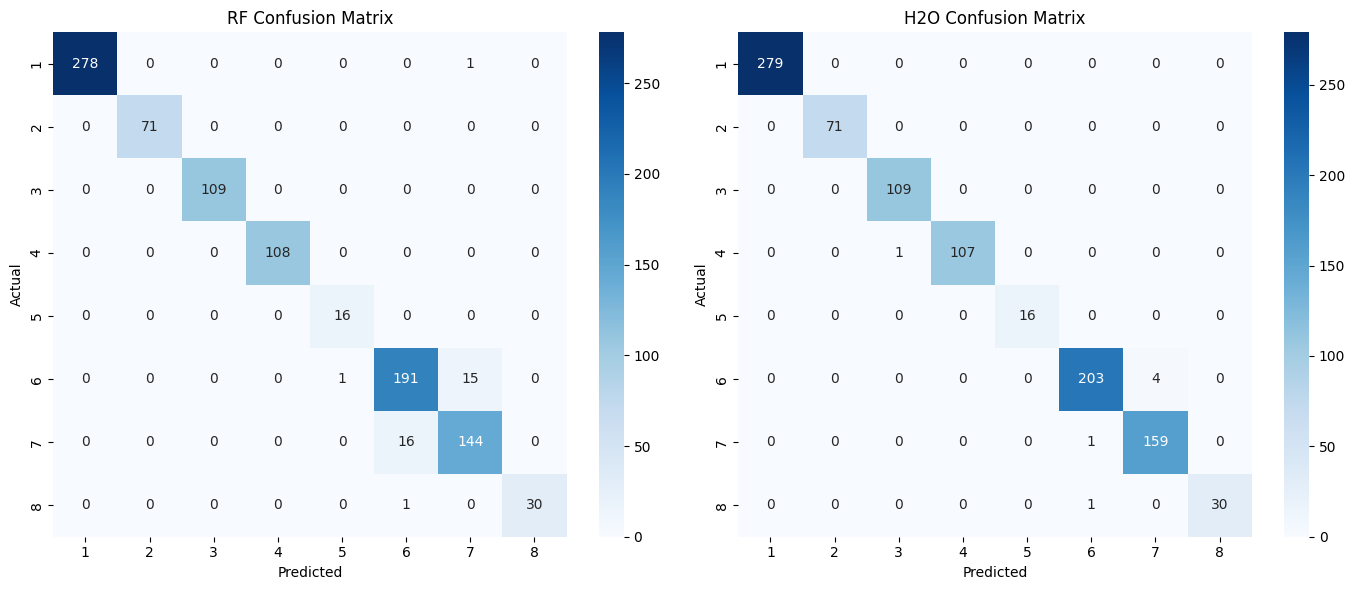

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Предсказания RF
y_pred_rf = grid.predict(X_test)

# Предсказания H2O
h2o_test = h2o.H2OFrame(X_test)
y_pred_h2o = base_model.predict(h2o_test).as_data_frame()['predict']

# Метки классов в правильном порядке
labels = list(grid.best_estimator_.named_steps['clf'].classes_)

# Строим матрицы ошибок
cm_rf  = confusion_matrix(y_test,       y_pred_rf,  labels=labels)
cm_h2o = confusion_matrix(y_test, y_pred_h2o.astype(int), labels=labels)

# Визуализация heatmap рядом
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(cm_rf, annot=True, fmt='d', ax=axes[0],
            xticklabels=labels, yticklabels=labels, cmap='Blues')
axes[0].set_title('RF Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

sns.heatmap(cm_h2o, annot=True, fmt='d', ax=axes[1],
            xticklabels=labels, yticklabels=labels, cmap='Blues')
axes[1].set_title('H2O Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()
